## Face and Facial Keypoint detection

After you've trained a neural network to detect facial keypoints, you can then apply this network to *any* image that includes faces. The neural network expects a Tensor of a certain size as input and, so, to detect any face, you'll first have to do some pre-processing.

1. Detect all the faces in an image using a face detector (we'll be using a Haar Cascade detector in this notebook).
2. Pre-process those face images so that they are grayscale, and transformed to a Tensor of the input size that your net expects. This step will be similar to the `data_transform` you created and applied in Notebook 2, whose job was tp rescale, normalize, and turn any iimage into a Tensor to be accepted as input to your CNN.
3. Use your trained model to detect facial keypoints on the image.

---

In [1]:
!git clone https://github.com/egness/Udacity-CVND.git

Cloning into 'Udacity-CVND'...
remote: Enumerating objects: 65, done.
remote: Counting objects: 100% (65/65), done.
remote: Compressing objects: 100% (49/49), done.
remote: Total 65 (delta 15), reused 61 (delta 14), pack-reused 0
Unpacking objects: 100% (65/65), done.


In [0]:
!cp Udacity-CVND/1_Facial_Keypoint_Detection/models.py .
!cp Udacity-CVND/1_Facial_Keypoint_Detection/data_load.py .

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
!mv gdrive/My\ Drive/Colab\ Src/keypoints_model_1.pt .


In [5]:
# Install PyTorch on COLAB
# http://pytorch.org/
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
import torch

tcmalloc: large alloc 1073750016 bytes == 0x57a48000 @  0x7f769ed972a4 0x591a07 0x5b5d56 0x502e9a 0x506859 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x504c28 0x502540 0x502f3d 0x507641


In the next python cell we load in required libraries for this section of the project.

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

#### Select an image 

Select an image to perform facial keypoint detection on; you can select any image of faces in the `images/` directory.

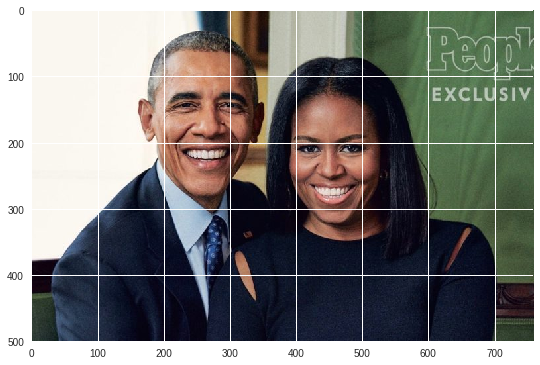

In [51]:
import cv2
# load in color image for face detection
image = cv2.imread('Udacity-CVND/1_Facial_Keypoint_Detection/images/obamas.jpg')

# switch red and blue color channels 
# --> by default OpenCV assumes BLUE comes first, not RED as in many images
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# plot the image
fig = plt.figure(figsize=(9,9))
plt.imshow(image)

## Detect all faces in an image

Next, you'll use one of OpenCV's pre-trained Haar Cascade classifiers, all of which can be found in the `detector_architectures/` directory, to find any faces in your selected image.

In the code below, we loop over each face in the original image and draw a red square on each face (in a copy of the original image, so as not to modify the original). You can even [add eye detections](https://docs.opencv.org/3.4.1/d7/d8b/tutorial_py_face_detection.html) as an *optional* exercise in using Haar detectors.

An example of face detection on a variety of images is shown below.

<img src='https://github.com/egness/Udacity-CVND/blob/master/1_Facial_Keypoint_Detection/images/haar_cascade_ex.png?raw=1' width=80% height=80%/>


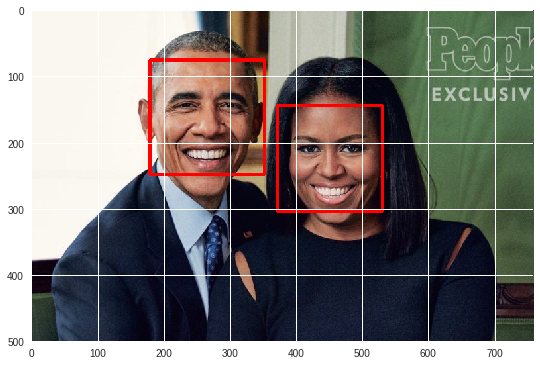

In [52]:
# load in a haar cascade classifier for detecting frontal faces
face_cascade = cv2.CascadeClassifier('Udacity-CVND/1_Facial_Keypoint_Detection/detector_architectures/haarcascade_frontalface_default.xml')

# run the detector
# the output here is an array of detections; the corners of each detection box
# if necessary, modify these parameters until you successfully identify every face in a given image
faces = face_cascade.detectMultiScale(image, 1.2, 2)

# make a copy of the original image to plot detections on
image_with_detections = image.copy()

# loop over the detected faces, mark the image where each face is found
for (x,y,w,h) in faces:
    # draw a rectangle around each detected face
    # you may also need to change the width of the rectangle drawn depending on image resolution
    cv2.rectangle(image_with_detections,(x,y),(x+w,y+h),(255,0,0),3) 

fig = plt.figure(figsize=(9,9))

plt.imshow(image_with_detections)

## Loading in a trained model

Once you have an image to work with (and, again, you can select any image of faces in the `images/` directory), the next step is to pre-process that image and feed it into your CNN facial keypoint detector.

First, load your best model by its filename.

In [11]:
import torch
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Available device:", device)

## TODO [DONE]: Once you've define the network, you can instantiate it
# one example conv layer has been provided for you
from models import NamishNet

# Colab modification: the entire model is moved to the GPU
# Note that his network is only used for the initial (pre-train) testing. The model used for training is loaded later.
net = NamishNet(originalDropout=False, actF=F.relu).cuda()


## TODO: load the best saved model parameters (by your path name)
## You'll need to un-comment the line below and add the correct name for *your* saved model
# net.load_state_dict(torch.load('saved_models/keypoints_model_1.pt'))
net.load_state_dict(torch.load('keypoints_model_1.pt'))
## print out your net and prepare it for testing (uncomment the line below)
net.eval()

Available device: cuda


NamishNet(
  (conv1): Conv2d(1, 32, kernel_size=(4, 4), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(2, 2), stride=(1, 1))
  (conv4): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.3)
  (dropout2): Dropout(p=0.3)
  (dropout3): Dropout(p=0.3)
  (dropout4): Dropout(p=0.3)
  (dropout5): Dropout(p=0.3)
  (dropout6): Dropout(p=0.3)
  (d1): Linear(in_features=43264, out_features=1000, bias=True)
  (d2): Linear(in_features=1000, out_features=1000, bias=True)
  (d3): Linear(in_features=1000, out_features=136, bias=True)
)

## Keypoint detection

Now, we'll loop over each detected face in an image (again!) only this time, you'll transform those faces in Tensors that your CNN can accept as input images.

### TODO: Transform each detected face into an input Tensor

You'll need to perform the following steps for each detected face:
1. Convert the face from RGB to grayscale
2. Normalize the grayscale image so that its color range falls in [0,1] instead of [0,255]
3. Rescale the detected face to be the expected square size for your CNN (224x224, suggested)
4. Reshape the numpy image into a torch image.

**Hint**: The sizes of faces detected by a Haar detector and the faces your network has been trained on are of different sizes. If you find that your model is generating keypoints that are too small for a given face, try adding some padding to the detected `roi` before giving it as input to your model.

You may find it useful to consult to transformation code in `data_load.py` to help you perform these processing steps.


### TODO: Detect and display the predicted keypoints

After each face has been appropriately converted into an input Tensor for your network to see as input, you can apply your `net` to each face. The ouput should be the predicted the facial keypoints. These keypoints will need to be "un-normalized" for display, and you may find it helpful to write a helper function like `show_keypoints`. You should end up with an image like the following with facial keypoints that closely match the facial features on each individual face:

<img src='https://github.com/egness/Udacity-CVND/blob/master/1_Facial_Keypoint_Detection/images/michelle_detected.png?raw=1' width=30% height=30%/>




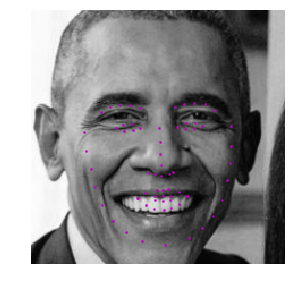

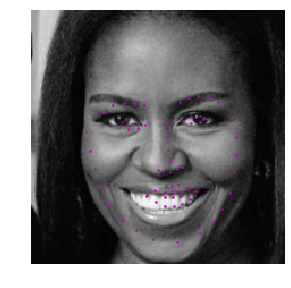

In [62]:
def show_all_keypoints(image, predicted_key_pts):
    """Show image with predicted keypoints"""
    # image is grayscale
    plt.imshow(image, cmap='gray')
    plt.scatter(predicted_key_pts[:, 0], predicted_key_pts[:, 1], s=20, marker='.', c='m')

    
image_copy = np.copy(image)

# loop over the detected faces from your haar cascade
for i, (x,y,w,h) in enumerate(faces):
    # Select the region of interest that is the face in the image 
    
    roi = image_copy[y-20:y+h+20, x-20:x+w+20]
    
    ## TODO: Convert the face region from RGB to grayscale
    roi = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
    
    ## TODO: Normalize the grayscale image so that its color range falls in [0,1] instead of [0,255]
    roi = roi / 255.0
    
    ## TODO: Rescale the detected face to be the expected square size for your CNN (224x224, suggested)
    roi = cv2.resize(roi, (224, 224)).reshape(224, 224, 1)
    roi_orig = np.copy(roi)
    
    ## TODO: Reshape the numpy image shape (H x W x C) into a torch image shape (C x H x W)
    roi = torch.from_numpy(roi.transpose(2, 0, 1))   
    roi = roi.type(torch.cuda.FloatTensor)
    roi = roi.unsqueeze(0)
    
    ## TODO: Make facial keypoint predictions using your loaded, trained network 
    ps = net(roi)
    ps = ps.view(68, 2)    
    ps = ps.data.cpu().numpy()
    ps = ps * 50.0 + 100
    
    ## TODO: Display each detected face and the corresponding keypoints 
    plt.figure(figsize=(10, 8))
    plt.subplot(1, 2, i+1)
    plt.axis('off')
    show_all_keypoints(np.squeeze(roi), ps)

plt.show()
